# Modelos de clasificación

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, classification_report

Como primer paso analizamos la posible correlación entre los ratios obtenidos en el notbook ratios

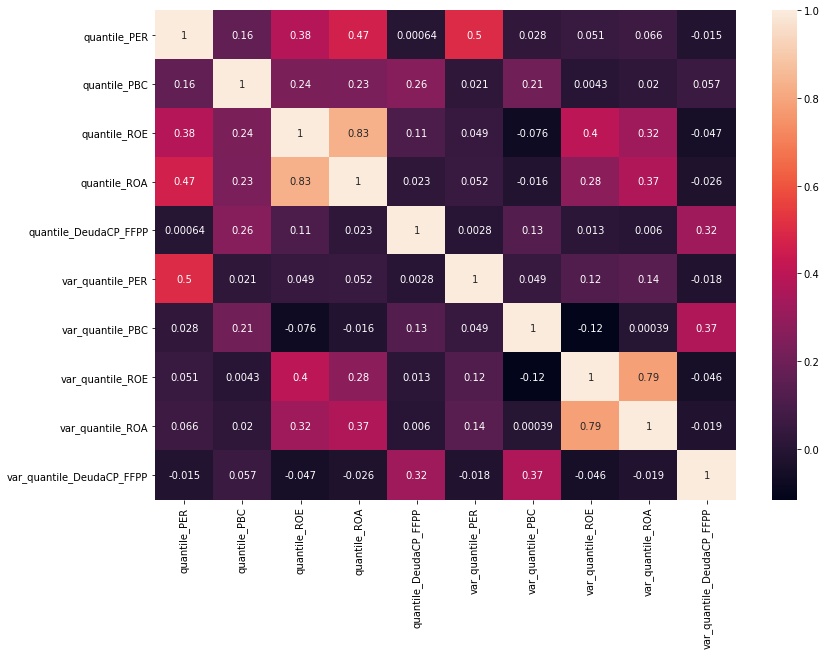

In [2]:
df = pd.read_csv("../tablas/dataformodel.csv", usecols=['quantile_PER', 'var_quantile_PER',
                                                        'quantile_PBC', 'var_quantile_PBC',
                                                        'quantile_ROA', 'var_quantile_ROA',
                                                        'quantile_ROE', 'var_quantile_ROE',
                                                        'quantile_DeudaCP_FFPP', 'var_quantile_DeudaCP_FFPP',
                                                        'Etiqueta'])

corrMatrix = df.corr()
plt.figure(figsize=(13,9))
sn.heatmap(corrMatrix, annot=True)
plt.show()

Podemos observar una correlación muy fuerte entre el ROE y el ROA, así que prescindimos del ROE, así como de su variación.

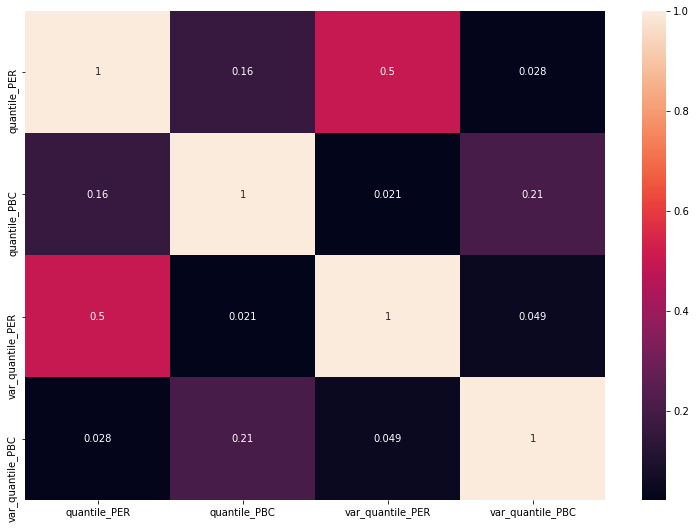

In [3]:
df = pd.read_csv("../tablas/dataformodel.csv", usecols=['quantile_PER', 'var_quantile_PER',
                                                        'quantile_PBC', 'var_quantile_PBC',
                                                        'Etiqueta'])

corrMatrix = df.corr()
plt.figure(figsize=(13,9))
sn.heatmap(corrMatrix, annot=True)
plt.show()

Eliminamos nans

In [4]:
df=df.replace([np.inf, -np.inf], np.nan)
for column in df.columns:
    df=df[df[column].notnull()]
df=df.reset_index(drop=True)

In [5]:
df.describe()

,quantile_PER,quantile_PBC,var_quantile_PER,var_quantile_PBC
count,12034.000000,12034.000000,12034.000000,12034.000000
mean,49.901952,49.895279,-0.002065,-0.011160
std,28.726802,28.723157,28.818244,11.847869
min,0.163934,0.163934,-99.179251,-99.344262
25%,25.000000,25.081967,-7.790642,-2.814570
50%,50.000000,49.836066,-0.161499,0.166113
75%,74.754098,74.754098,7.590812,3.237456
max,100.000000,100.000000,99.015317,99.337748


## Preparación del modelo

In [6]:
variables = list(df.columns)
variables.remove('Etiqueta')
X = df[variables].values
y = df['Etiqueta']

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, shuffle=True)

### LogisticRegression

In [8]:
from sklearn.linear_model import LogisticRegression
# Create an instance of the classifier
clf=LogisticRegression(max_iter=200)

In [9]:
clf.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [10]:
cross_val_score(clf,X_train,y_train,cv=10,scoring="accuracy").mean()

0.5479369736379083

In [11]:
a=df.groupby('Etiqueta').count()
a['%']= a.iloc[0:,1]/a.iloc[0:,1].sum()
a

,quantile_PER,quantile_PBC,var_quantile_PER,var_quantile_PBC,%
Etiqueta,,,,,
Mejor,5598,5598,5598,5598,0.465182
Peor,6436,6436,6436,6436,0.534818


In [12]:
print(classification_report(y_test,clf.predict(X_test)))

              precision    recall  f1-score   support

       Mejor       0.50      0.27      0.35      1120
        Peor       0.55      0.77      0.64      1287

    accuracy                           0.54      2407
   macro avg       0.53      0.52      0.50      2407
weighted avg       0.53      0.54      0.51      2407



In [13]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, clf.predict(X_test))
print(confusion_matrix)

[[303 817]
 [299 988]]


In [14]:
clf.score(X_test, y_test)

0.5363523057748234

### Kneighbors

In [15]:
# Load the library
from sklearn.neighbors import KNeighborsClassifier
# Create an instance of the classifier
clfk=KNeighborsClassifier(n_neighbors=5)
# Fit the data
clfk.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
knGrid = GridSearchCV(clfk,cv=5,scoring="accuracy",param_grid={'n_neighbors':np.arange(1,20)})
knGrid.fit(X_train,y_train)
knGrid.best_params_

{'n_neighbors': 19}

In [18]:
best_n_neighbors=knGrid.best_params_.get('n_neighbors')

In [19]:
clfk=KNeighborsClassifier(n_neighbors=best_n_neighbors)
clfk.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=19, p=2,
                     weights='uniform')

In [20]:
cross_val_score(clfk,X_train,y_train,cv=5,scoring="accuracy").mean()

0.5400444498388424

In [21]:
print(classification_report(y_test,clfk.predict(X_test)))

              precision    recall  f1-score   support

       Mejor       0.49      0.45      0.47      1120
        Peor       0.55      0.59      0.57      1287

    accuracy                           0.53      2407
   macro avg       0.52      0.52      0.52      2407
weighted avg       0.52      0.53      0.52      2407



In [22]:
clfk.score(X_test, y_test, sample_weight=None)

0.5267968425425841

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, clfk.predict(X_test))
print(confusion_matrix)

[[504 616]
 [523 764]]


### Decision Tree

In [24]:
# Import library
from sklearn.tree import DecisionTreeClassifier

In [25]:
clfTree = GridSearchCV(DecisionTreeClassifier(),
                      param_grid = {"max_depth":np.arange(2,10),
                                   "min_samples_leaf": np.arange(2,20,1)},
                      cv=5,
                       scoring="accuracy"
                      )
clfTree.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
       

In [26]:
clfTree.best_score_

0.5460698304810453

In [27]:
clfTree.best_params_

{'max_depth': 5, 'min_samples_leaf': 12}

In [28]:
best_max_depth=clfTree.best_params_.get('max_depth')
best_min_samples_leaf=clfTree.best_params_.get('min_samples_leaf')

In [29]:
clfTree = DecisionTreeClassifier(random_state=0, max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf)
clfTree.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=12, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [30]:
 clfTree.score(X_test, y_test, sample_weight=None)

0.5471541337764853

In [31]:
print(classification_report(y_test,clfTree.predict(X_test)))

              precision    recall  f1-score   support

       Mejor       0.53      0.23      0.32      1120
        Peor       0.55      0.82      0.66      1287

    accuracy                           0.55      2407
   macro avg       0.54      0.53      0.49      2407
weighted avg       0.54      0.55      0.50      2407



### Random Forest

In [53]:
from sklearn.ensemble import RandomForestClassifier

In [54]:
clf_rf0 = RandomForestClassifier(max_depth=3,
                               min_samples_leaf=5,
                               n_estimators=100,
                               n_jobs=-1)

In [55]:
clf_rf = GridSearchCV(clf_rf0,
                      param_grid = {"max_depth":np.arange(2,10),
                                   "min_samples_leaf": np.arange(2,20,2)},
                      cv=4,
                       scoring="accuracy"
                      )
clf_rf.fit(X_train,y_train)

GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=3,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=5,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False,
                                              random_sta

In [56]:
print(clf_rf.best_score_)
print(clf_rf.best_params_)

0.5432259396943412
{'max_depth': 9, 'min_samples_leaf': 6}


In [57]:
best_max_depth=clf_rf.best_params_.get('max_depth')
best_min_samples_leaf=clf_rf.best_params_.get('min_samples_leaf')

In [58]:
clf_rf1 = RandomForestClassifier(max_depth=best_max_depth,
                               min_samples_leaf=best_min_samples_leaf,
                               n_estimators=300,
                               n_jobs=-1)
clf_rf1.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [59]:
cross_val_score(clf_rf1,X_train,y_train,cv=4,scoring="accuracy").mean()

0.5311200605810271

In [60]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test,clf_rf1.predict(X_test)))

              precision    recall  f1-score   support

       Mejor       0.40      0.36      0.38       111
        Peor       0.58      0.62      0.60       159

    accuracy                           0.51       270
   macro avg       0.49      0.49      0.49       270
weighted avg       0.50      0.51      0.51       270



In [61]:
print(confusion_matrix(y_test,clf_rf1.predict(X_test)))

[[40 71]
 [61 98]]
